In [1]:
import pandas as pd
import numpy as np
import glob
import os
import re
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# --- CONFIGURATION ---
# Define the Root Path relative to this notebook
def get_project_root():
    path = Path.cwd()
    while path.name:
        if (path / 'pyproject.toml').exists(): return path
        path = path.parent
    return Path.cwd()

PROJECT_ROOT = get_project_root()
DATA_DIR = PROJECT_ROOT / "data"

# Mappings
TRAFFIC_TO_AQ_MAP = {
    'LAWRENCE AVE E / KENNEDY RD': 'Toronto East',
    'STEELES AVE W / DUFFERIN ST': 'Toronto North',
    'FRONT ST W / JOHN ST / PRIVATE ACCESS': 'Toronto Downtown',
    'ISLINGTON AVE / 401 C W ISLINGTON N RAMP / ALLENBY AVE': 'Toronto West'
}

AQ_STATION_NAMES = {
    'Toronto East (33003)': 'Toronto East',
    'Toronto North (34021)': 'Toronto North',
    'Toronto Downtown (31129)': 'Toronto Downtown',
    'Toronto West (35125)': 'Toronto West'
}

In [2]:
def load_and_clean_aq(data_dir):
    all_data = []
    files = glob.glob(str(data_dir / "air_quality" / "aq_data" / "**" / "*.csv"), recursive=True)
    
    print(f"Loading {len(files)} Air Quality files...")
    
    for file_path in files:
        try:
            # Metadata extraction
            with open(file_path, 'r', encoding='latin1') as f:
                meta_lines = [next(f) for _ in range(10)]
                raw_name = meta_lines[1].split(',')[1].strip()
            
            station_name = AQ_STATION_NAMES.get(raw_name, raw_name)
            
            # Load Data
            df = pd.read_csv(file_path, skiprows=10, index_col=False)
            df.replace([9999, -999, 9999.0, -999.0], np.nan, inplace=True)
            
            # Date Parsing
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
            df.dropna(subset=['Date'], inplace=True)
            
            # Calculate Mean
            hour_cols = [c for c in df.columns if c.startswith('H') and c[1:].isdigit()]
            df['NO2_Mean'] = df[hour_cols].mean(axis=1)
            
            # Keep essentials
            df = df[['Date', 'NO2_Mean']].copy()
            df['Station'] = station_name
            
            all_data.append(df)
            
        except Exception as e:
            print(f"Error reading {Path(file_path).name}: {e}")

    # Combine
    full_df = pd.concat(all_data, ignore_index=True)
    
    # 1. Group by Station/Date to merge split rows
    df_clean = full_df.groupby(['Station', 'Date'], as_index=False)['NO2_Mean'].mean()
    
    # 2. Reindex to handle MISSING DATES
    min_date, max_date = df_clean['Date'].min(), df_clean['Date'].max()
    full_range = pd.date_range(min_date, max_date, freq='D')
    
    def fill_gaps(group):
        # FIX: The station name is the 'name' of the group, not a column inside it
        station_name = group.name
        
        # Reindex
        group = group.set_index('Date').reindex(full_range)
        
        # Assign station name to all rows (including the new gap rows)
        group['Station'] = station_name
        
        return group.reset_index().rename(columns={'index': 'Date'})

    # Apply reindexing
    df_clean = df_clean.groupby('Station', group_keys=False).apply(fill_gaps)

    # 3. Impute Missing Values (Forward Fill, limit 7 days)
    df_clean['NO2_Mean'] = df_clean.groupby('Station')['NO2_Mean'].ffill(limit=7)
    
    # Drop remaining NaNs (e.g. leading missing values)
    df_clean.dropna(subset=['NO2_Mean'], inplace=True)
    
    print(f"✅ AQ Data Loaded: {len(df_clean)} rows across {df_clean['Station'].nunique()} stations.")
    return df_clean

df_aq = load_and_clean_aq(DATA_DIR)
df_aq.head()

Loading 7 Air Quality files...
✅ AQ Data Loaded: 7667 rows across 7 stations.


,Date,NO2_Mean,Station
0,2022-01-01,8.008333,Burlington (44008)
1,2022-01-02,4.987500,Burlington (44008)
2,2022-01-03,15.013043,Burlington (44008)
3,2022-01-04,13.029167,Burlington (44008)
4,2022-01-05,12.291667,Burlington (44008)


In [3]:
def load_traffic(data_dir):
    traffic_path = data_dir / "traffic" / "filtered_roads_with_sums.csv"
    print(f"Loading Traffic Data from {traffic_path.name}...")
    
    df = pd.read_csv(traffic_path)
    
    # Identify date columns
    date_col_pattern = re.compile(r"^x\d{4}_\d{2}_\d{2}$")
    date_cols = [c for c in df.columns if date_col_pattern.match(c)]
    
    # Melt
    df_long = df.melt(
        id_vars=['camera_road'], 
        value_vars=date_cols, 
        var_name='Date_Str', 
        value_name='Traffic_Count'
    )
    
    # Process Dates
    df_long['Date'] = pd.to_datetime(df_long['Date_Str'].str[1:], format='%Y_%m_%d')
    df_long['Station'] = df_long['camera_road'].map(TRAFFIC_TO_AQ_MAP)
    
    # Filter valid stations
    df_final = df_long.dropna(subset=['Station', 'Traffic_Count'])
    
    # Aggregate (Sum volume if multiple cameras -> 1 Station)
    df_final = df_final.groupby(['Station', 'Date'], as_index=False)['Traffic_Count'].sum()
    
    # --- IMPUTATION STRATEGY: FILL GAPS WITH DAY-OF-WEEK AVERAGE ---
    
    # 1. Reindex to create the missing rows (The "Month Long Gaps")
    min_date, max_date = df_final['Date'].min(), df_final['Date'].max()
    full_range = pd.date_range(min_date, max_date, freq='D')
    
    def reindex_traffic(group):
        station_name = group.name
        group = group.set_index('Date').reindex(full_range)
        group['Station'] = station_name
        return group.reset_index().rename(columns={'index': 'Date'})
    
    df_final = df_final.groupby('Station', group_keys=False).apply(reindex_traffic)
    
    # 2. Calculate Day of Week for every row (including the empty ones)
    df_final['DayOfWeek'] = df_final['Date'].dt.dayofweek
    
    # 3. Impute: "If this is a missing Tuesday at Toronto East, fill it with the average Toronto East Tuesday"
    # We group by [Station, DayOfWeek] so Monday averages don't mix with Sunday averages
    df_final['Traffic_Count'] = df_final['Traffic_Count'].fillna(
        df_final.groupby(['Station', 'DayOfWeek'])['Traffic_Count'].transform('mean')
    )
    
    # 4. Clean up
    df_final.drop(columns=['DayOfWeek'], inplace=True)
    df_final.dropna(subset=['Traffic_Count'], inplace=True) # Drop if a station has NO data for a specific day-of-week ever
    
    print(f"✅ Traffic Data Loaded: {len(df_final)} rows.")
    return df_final

df_traffic = load_traffic(DATA_DIR)
df_traffic.head()

Loading Traffic Data from filtered_roads_with_sums.csv...
✅ Traffic Data Loaded: 5468 rows.


,Date,Traffic_Count,Station
0,2022-02-03,320.0,Toronto Downtown
1,2022-02-04,269.0,Toronto Downtown
2,2022-02-05,161.0,Toronto Downtown
3,2022-02-06,98.0,Toronto Downtown
4,2022-02-07,151.0,Toronto Downtown


In [4]:
def load_weather_with_direction(data_dir):
    all_weather = []
    weather_files = glob.glob(str(data_dir / "weather" / "weather_data" / "*.csv"))
    
    filename_map = {
        'Toronto_City_Centre_Downtown': 'Toronto Downtown',
        'Toronto_City_Ontario_East': 'Toronto East',
        'Toronto_Pearson_Intl_West': 'Toronto West',
        'Toronto_York_North': 'Toronto North'
    }

    for fpath in weather_files:
        fname = Path(fpath).stem
        station_name = filename_map.get(fname)
        
        # Robust Mapping Fallback
        if not station_name:
            if 'East' in fname: station_name = 'Toronto East'
            elif 'North' in fname: station_name = 'Toronto North'
            elif 'West' in fname: station_name = 'Toronto West'
            elif 'Downtown' in fname: station_name = 'Toronto Downtown'

        if station_name:
            try:
                df = pd.read_csv(fpath)
                df['Station'] = station_name
                
                # Normalize Date
                date_col = 'Date/Time' if 'Date/Time' in df.columns else 'Date'
                df['Date'] = pd.to_datetime(df[date_col]).dt.normalize()
                
                # Map Columns (Adding 'Dir of Max Gust')
                # 'Dir of Max Gust (10s deg)' means '18' = 180 degrees
                rename_map = {
                    'Mean Temp (°C)': 'Temp', 
                    'Total Precip (mm)': 'Precip', 
                    'Spd of Max Gust (km/h)': 'Wind_Gust',
                    'Dir of Max Gust (10s deg)': 'Wind_Dir_Raw' 
                }
                df.rename(columns=rename_map, inplace=True)
                
                # Convert '10s of degrees' to actual degrees (multiply by 10)
                if 'Wind_Dir_Raw' in df.columns:
                    df['Wind_Dir'] = df['Wind_Dir_Raw'] * 10
                else:
                    df['Wind_Dir'] = np.nan

                # Force columns to exist
                for c in ['Temp', 'Precip', 'Wind_Gust', 'Wind_Dir']:
                    if c not in df.columns: df[c] = np.nan
                
                cols = ['Date', 'Station', 'Temp', 'Precip', 'Wind_Gust', 'Wind_Dir']
                all_weather.append(df[cols])
            except Exception as e:
                print(f"Skipping {fname}: {e}")

    df_weather = pd.concat(all_weather, ignore_index=True)
    df_weather = df_weather.sort_values(['Station', 'Date'])
    
    # --- IMPUTATION ---
    # 1. Fill small gaps
    for col in ['Temp', 'Precip']:
        df_weather[col] = df_weather.groupby('Station')[col].transform(lambda x: x.ffill().bfill())
        
    # 2. Regional Imputation for Wind (Speed AND Direction)
    # If East/North are missing wind, grab the daily average from West/Downtown
    for col in ['Wind_Gust', 'Wind_Dir']:
        regional_avg = df_weather.groupby('Date')[col].transform('mean')
        df_weather[col] = df_weather[col].fillna(regional_avg)
    
    # 3. Final Cleanup
    df_weather['Wind_Gust'] = df_weather['Wind_Gust'].fillna(0.0)
    df_weather['Wind_Dir'] = df_weather['Wind_Dir'].fillna(0.0) # Assume North if completely unknown
    
    df_weather = df_weather.dropna(subset=['Temp'])
    print(f"✅ Weather Data Loaded with Direction: {len(df_weather)} rows")
    return df_weather

df_weather = load_weather_with_direction(DATA_DIR)

✅ Weather Data Loaded with Direction: 5844 rows


In [5]:
print(f"Shape before merge:")
print(f"  AQ Data:      {df_aq.shape}")
print(f"  Traffic Data: {df_traffic.shape}")
print(f"  Weather Data: {df_weather.shape}")

Shape before merge:
  AQ Data:      (7667, 3)
  Traffic Data: (5468, 3)
  Weather Data: (5844, 6)


In [6]:
# --- MERGING DATASETS ---

print(f"Input Sizes -> AQ: {len(df_aq)} | Traffic: {len(df_traffic)} | Weather: {len(df_weather)}")

# 1. Merge AQ and Traffic (Inner Join)
df_merged = pd.merge(df_aq, df_traffic, on=['Date', 'Station'], how='inner')
print(f"After AQ+Traffic Merge: {len(df_merged)} rows")

# 2. Merge Weather (Inner Join now safe because we imputed missing wind)
df_master = pd.merge(df_merged, df_weather, on=['Date', 'Station'], how='inner')

print(f"✅ FINAL Master Dataset: {len(df_master)} rows")
print(f"Stations present: {df_master['Station'].unique()}")

df_master.head()

Input Sizes -> AQ: 7667 | Traffic: 5468 | Weather: 5844
After AQ+Traffic Merge: 4247 rows
✅ FINAL Master Dataset: 4247 rows
Stations present: <StringArray>
['Toronto Downtown', 'Toronto East', 'Toronto North', 'Toronto West']
Length: 4, dtype: str


,Date,NO2_Mean,Station,Traffic_Count,Temp,Precip,Wind_Gust,Wind_Dir
0,2022-02-03,14.404167,Toronto Downtown,320.0,-5.4,1.0,48.0,320.0
1,2022-02-04,21.079167,Toronto Downtown,269.0,-10.2,0.2,42.0,40.0
2,2022-02-05,15.370833,Toronto Downtown,161.0,-9.9,0.0,37.0,310.0
3,2022-02-06,10.116667,Toronto Downtown,98.0,-2.9,0.0,54.0,200.0
4,2022-02-07,16.562500,Toronto Downtown,151.0,1.0,0.0,41.0,230.0


In [7]:
# --- FEATURE ENGINEERING ---

# 1. Wind Vectors (Crucial Step)
# Convert Degrees to Radians, then to Sin/Cos
# Sin = East/West component (-1 is West, +1 is East)
# Cos = North/South component (-1 is South, +1 is North)
df_master['Wind_Sin'] = np.sin(np.deg2rad(df_master['Wind_Dir']))
df_master['Wind_Cos'] = np.cos(np.deg2rad(df_master['Wind_Dir']))

# 2. Temporal Features
df_master['DayOfWeek'] = df_master['Date'].dt.dayofweek
df_master['Month'] = df_master['Date'].dt.month
df_master['IsWeekend'] = df_master['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# 3. Lags (History)
df_master['NO2_Lag1'] = df_master.groupby('Station')['NO2_Mean'].shift(1)
df_master['Traffic_Lag1'] = df_master.groupby('Station')['Traffic_Count'].shift(1)

df_master.dropna(inplace=True)
print(f"✅ Features Added. New Columns: Wind_Sin, Wind_Cos")

✅ Features Added. New Columns: Wind_Sin, Wind_Cos


In [8]:
# --- ABLATION STUDY: WITH WIND DIRECTION ---

# 1. Define Feature Sets
# Base = Weather (Now including Direction) + Time + History
features_base = [
    'Temp', 'Precip', 'Wind_Gust', 
    'Wind_Sin', 'Wind_Cos',             # <--- The new critical features 'Month',  
    'NO2_Lag1'                          
]

# Traffic = The signal we are testing
features_traffic = ['Traffic_Count', 'Traffic_Lag1']

features_full = features_traffic + features_base

ablation_results = []

print(f"{'STATION':<20} | {'BASE R²':<8} | {'FULL R²':<8} | {'RF GAIN':<8} | {'LR GAIN':<8} | {'COEFF (TODAY)'}")
print("-" * 90)

for station in df_master['Station'].unique():
    df_local = df_master[df_master['Station'] == station].copy()
    if len(df_local) < 50: continue
    
    y = df_local['NO2_Mean']
    
    # 2. Split Data (Same seed for fair comparison)
    # We create two X matrices: one with traffic, one without.
    X_full = df_local[features_full]
    X_base = df_local[features_base]
    
    X_train_f, X_test_f, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)
    X_train_b, X_test_b, _, _ = train_test_split(X_base, y, test_size=0.2, random_state=42)
    
    # --- RANDOM FOREST COMPARISON ---
    # Train Base (No Traffic)
    rf_base = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train_b, y_train)
    r2_base = r2_score(y_test, rf_base.predict(X_test_b))
    
    # Train Full (With Traffic)
    rf_full = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train_f, y_train)
    r2_full = r2_score(y_test, rf_full.predict(X_test_f))
    
    rf_gain = r2_full - r2_base
    
    # --- LINEAR REGRESSION COMPARISON ---
    lr_base = LinearRegression().fit(X_train_b, y_train)
    r2_lr_base = r2_score(y_test, lr_base.predict(X_test_b))
    
    lr_full = LinearRegression().fit(X_train_f, y_train)
    r2_lr_full = r2_score(y_test, lr_full.predict(X_test_f))
    
    lr_gain = r2_lr_full - r2_lr_base
    
    # Extract Coefficient for 'Traffic_Count'
    idx = features_full.index('Traffic_Count')
    coef = lr_full.coef_[idx]
    
    ablation_results.append({
        'Station': station,
        'RF_Gain': rf_gain,
        'LR_Gain': lr_gain,
        'Coef_Today': coef
    })
    
    print(f"{station:<20} | {r2_base:<8.4f} | {r2_full:<8.4f} | {rf_gain:<+8.4f} | {lr_gain:<+8.4f} | {coef:+.4f}")

print("-" * 90)

STATION              | BASE R²  | FULL R²  | RF GAIN  | LR GAIN  | COEFF (TODAY)
------------------------------------------------------------------------------------------
Toronto Downtown     | 0.2928   | 0.3370   | +0.0442  | +0.0045  | +0.0022
Toronto East         | 0.4647   | 0.4867   | +0.0220  | +0.0056  | -0.0000
Toronto North        | 0.4337   | 0.4400   | +0.0063  | +0.0017  | +0.0018
Toronto West         | 0.3501   | 0.4058   | +0.0557  | +0.0027  | -0.0004
------------------------------------------------------------------------------------------


Generating Partial Dependence Plots...
Rug plot (black ticks) will show EVERY data point distribution.


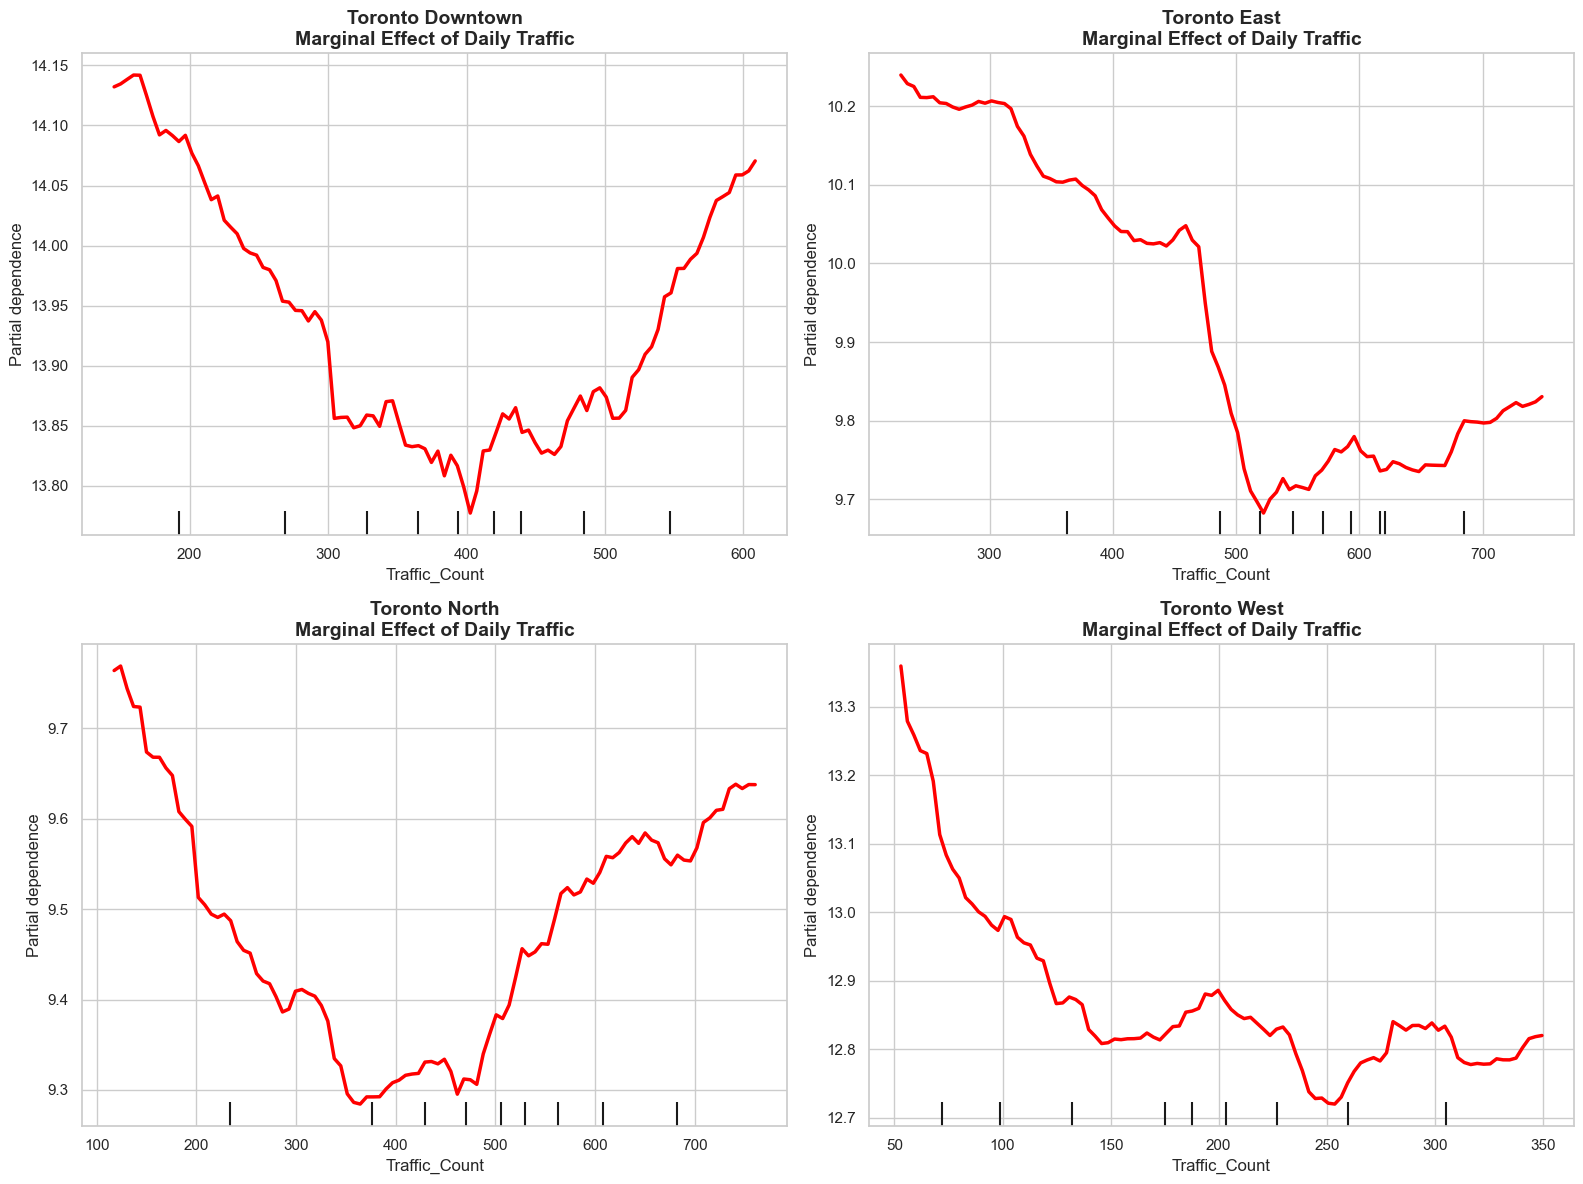

In [9]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- VISUALIZING THE MARGINAL IMPACT (WITH FULL RUG PLOT) ---

print("Generating Partial Dependence Plots...")
print("Rug plot (black ticks) will show EVERY data point distribution.")

# 1. Define Features
features_traffic = ['Traffic_Count', 'Traffic_Lag1']
features_base = [
    'Temp', 'Precip', 'Wind_Gust', 
    'Wind_Sin', 'Wind_Cos', 
    'Month', 'DayOfWeek',
    'NO2_Lag1'                          
]
full_feature_list = features_traffic + features_base

# 2. Setup Plot Grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# 3. Iterate through stations
for i, station in enumerate(sorted(df_master['Station'].unique())):
    ax = axes[i]
    
    # Isolate data
    df_local = df_master[df_master['Station'] == station].copy()
    
    # Safety Check
    if len(df_local) < 50: 
        ax.text(0.5, 0.5, "Insufficient Data", ha='center')
        continue
    
    X = df_local[full_feature_list]
    y = df_local['NO2_Mean']
    
    # Train Model (Increased estimators for smoother lines)
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X, y)
    
    # --- DRAW PDP CURVE ---
    display = PartialDependenceDisplay.from_estimator(
        model, 
        X, 
        features=['Traffic_Count'],
        kind='average',
        ax=ax,
        line_kw={'color': 'red', 'linewidth': 2.5}
    )
    
    # --- DRAW RUG PLOT (THE TICKS) ---
    # We set alpha=0.3 to handle overlapping ticks
    # We set lw=1 to make sure they are visible
    sns.rugplot(
        data=df_local, 
        x='Traffic_Count', 
        ax=ax, 
        height=0.08,     # Taller ticks (8% of axis height)
        color='black', 
        alpha=0.3,       # Transparency shows density
        lw=1,            # Line width
        expand_margins=False
    )

    # --- FORMATTING ---
    ax.set_title(f"{station}\nMarginal Effect of Daily Traffic", fontsize=14, fontweight='bold')
    ax.set_ylabel("Predicted NO2 (ppb)", fontsize=11)
    ax.set_xlabel("Daily Traffic Volume", fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.6)

# Final Layout Adjustments
plt.tight_layout()
plt.show()

Fitting GAMs... (This allows for smooth non-linear curves)


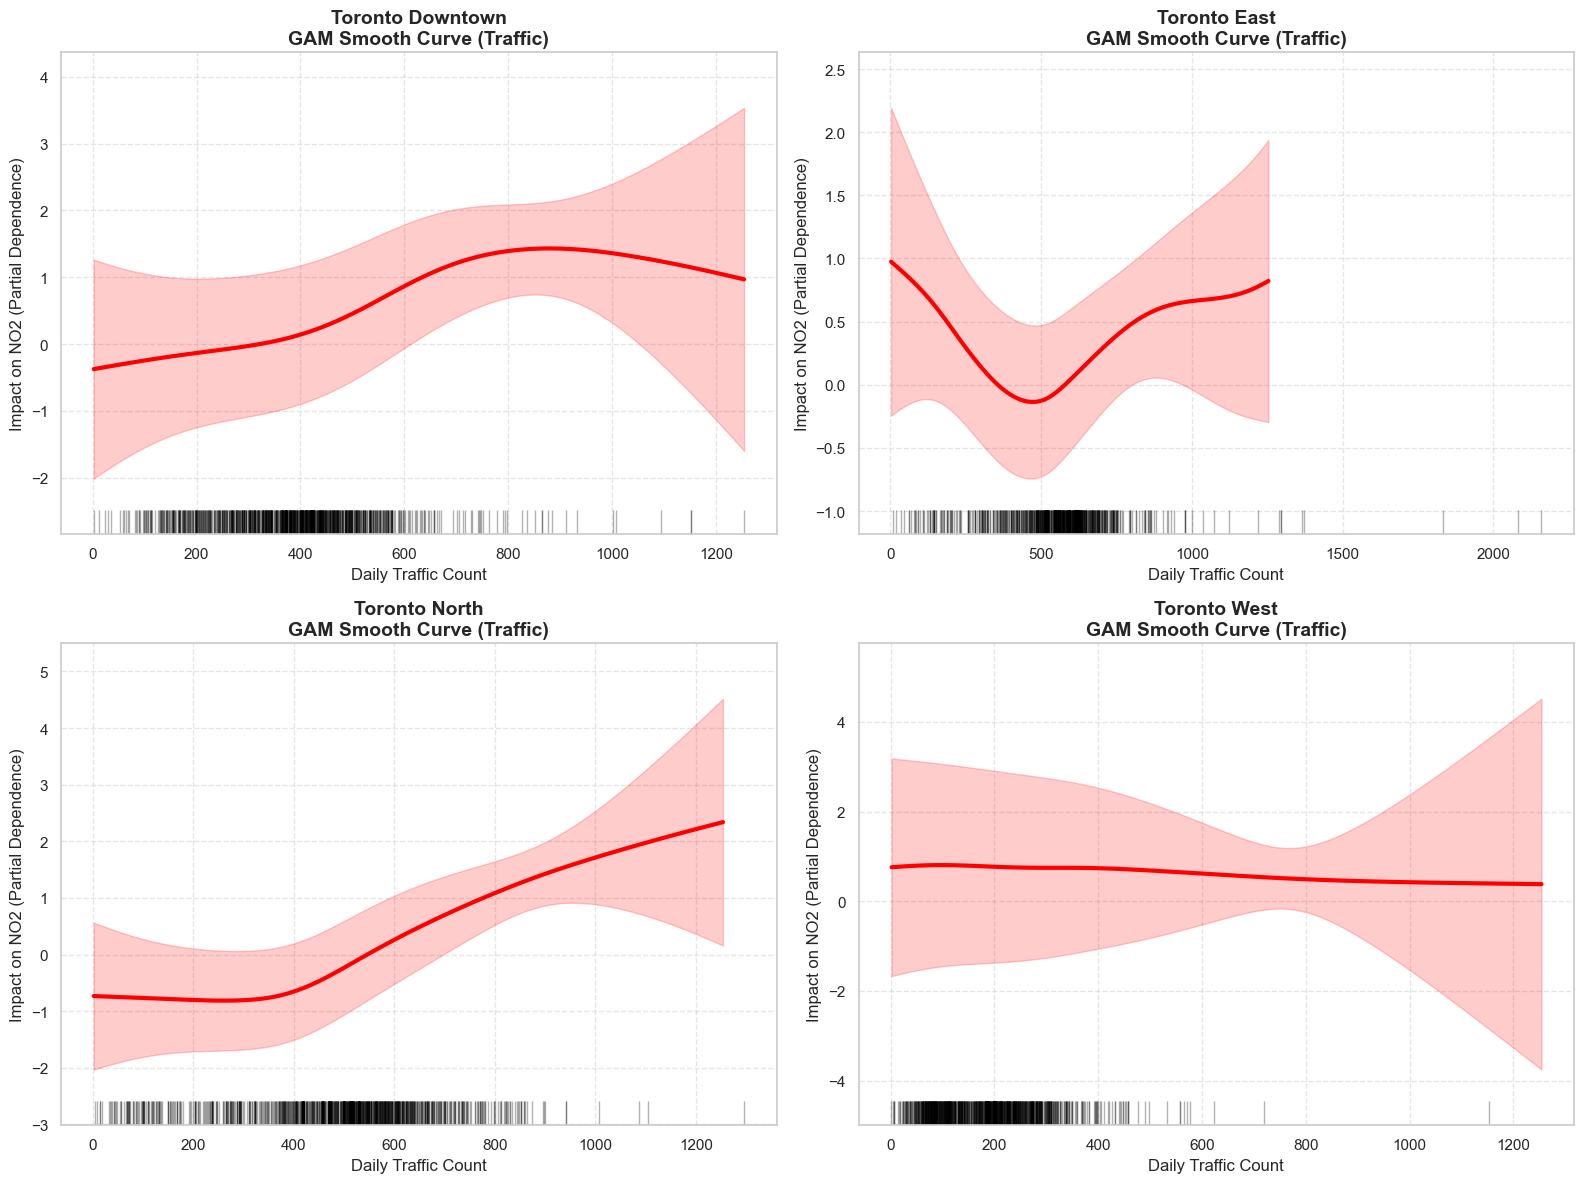

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     23.3902
Link Function:                     IdentityLink Log Likelihood:                                 -2946.3733
Number of Samples:                         1062 AIC:                                             5941.5269
                                                AICc:                                            5942.7217
                                                GCV:                                               16.0105
                                                Scale:                                              3.9214
                                                Pseudo R-Squared:                                   0.4074
Feature Function                  Lam

/var/folders/d7/l_md2zmj1wjglhzg6d75xsdh0000gn/T/ipykernel_48911/866510157.py:62: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(f"Model Formula Used: {gam.summary()}")


In [ ]:
from pygam import LinearGAM, s, f, l
import matplotlib.pyplot as plt

# --- GENERALIZED ADDITIVE MODELS (GAM) ---

print("Fitting GAMs... (This allows for smooth non-linear curves)")

# 1. Prepare Data
# GAMs in Python prefer clean Numpy arrays
feature_cols = [
    'Traffic_Count',    # Index 0: Target of interest
    'Traffic_Lag1',     # Index 1: Lag
    'Temp',             # Index 2: Weather
    'Wind_Gust',        # Index 3: Dispersion
    'Wind_Dir',         # Index 4: Direction (Needs Cyclic Spline)
    'NO2_Lag1',         # Index 5: Autoregression
    'Month'             # Index 6: Seasonality
]

# 2. Define the Model Formula
# s() = smooth spline (the curve)
gam_formula = s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, station in enumerate(sorted(df_master['Station'].unique())):
    ax = axes[i]
    
    # Isolate Station Data
    df_local = df_master[df_master['Station'] == station].dropna(subset=feature_cols + ['NO2_Mean']).copy()
    if len(df_local) < 50: continue
    
    X = df_local[feature_cols].values
    y = df_local['NO2_Mean'].values
    
    # 3. Fit the GAM
    # We use GridSearch to automatically find the smoothness (wiggliness) of the lines
    gam = LinearGAM(gam_formula).gridsearch(X, y, progress=False)
    
    
    # 4. Visualize the Partial Dependence for TRAFFIC COUNT (Index 0)
    # This extracts the smooth curve the model learned
    XX = gam.generate_X_grid(term=0) # Generate a grid for feature 0 (Traffic)
    pdp, confi = gam.partial_dependence(term=0, X=XX, width=0.95) # 95% Confidence Intervals
    
    # Plotting
    ax.plot(XX[:, 0], pdp, color='red', lw=3, label='Effect of Traffic')
    ax.fill_between(XX[:, 0], confi[:, 0], confi[:, 1], color='red', alpha=0.2, label='95% Confidence')
    
    # Add Rug Plot for context
    sns.rugplot(data=df_local, x='Traffic_Count', ax=ax, color='black', alpha=0.3, height=0.05)
    
    ax.set_title(f"{station}\nGAM Smooth Curve (Traffic)", fontsize=14, fontweight='bold')
    ax.set_xlabel("Daily Traffic Count")
    ax.set_ylabel("Impact on NO2 (Partial Dependence)")
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"Model Formula Used: {gam.summary()}")

Fitting GAMs... Generating relative Partial Dependence Plots (Centered)...


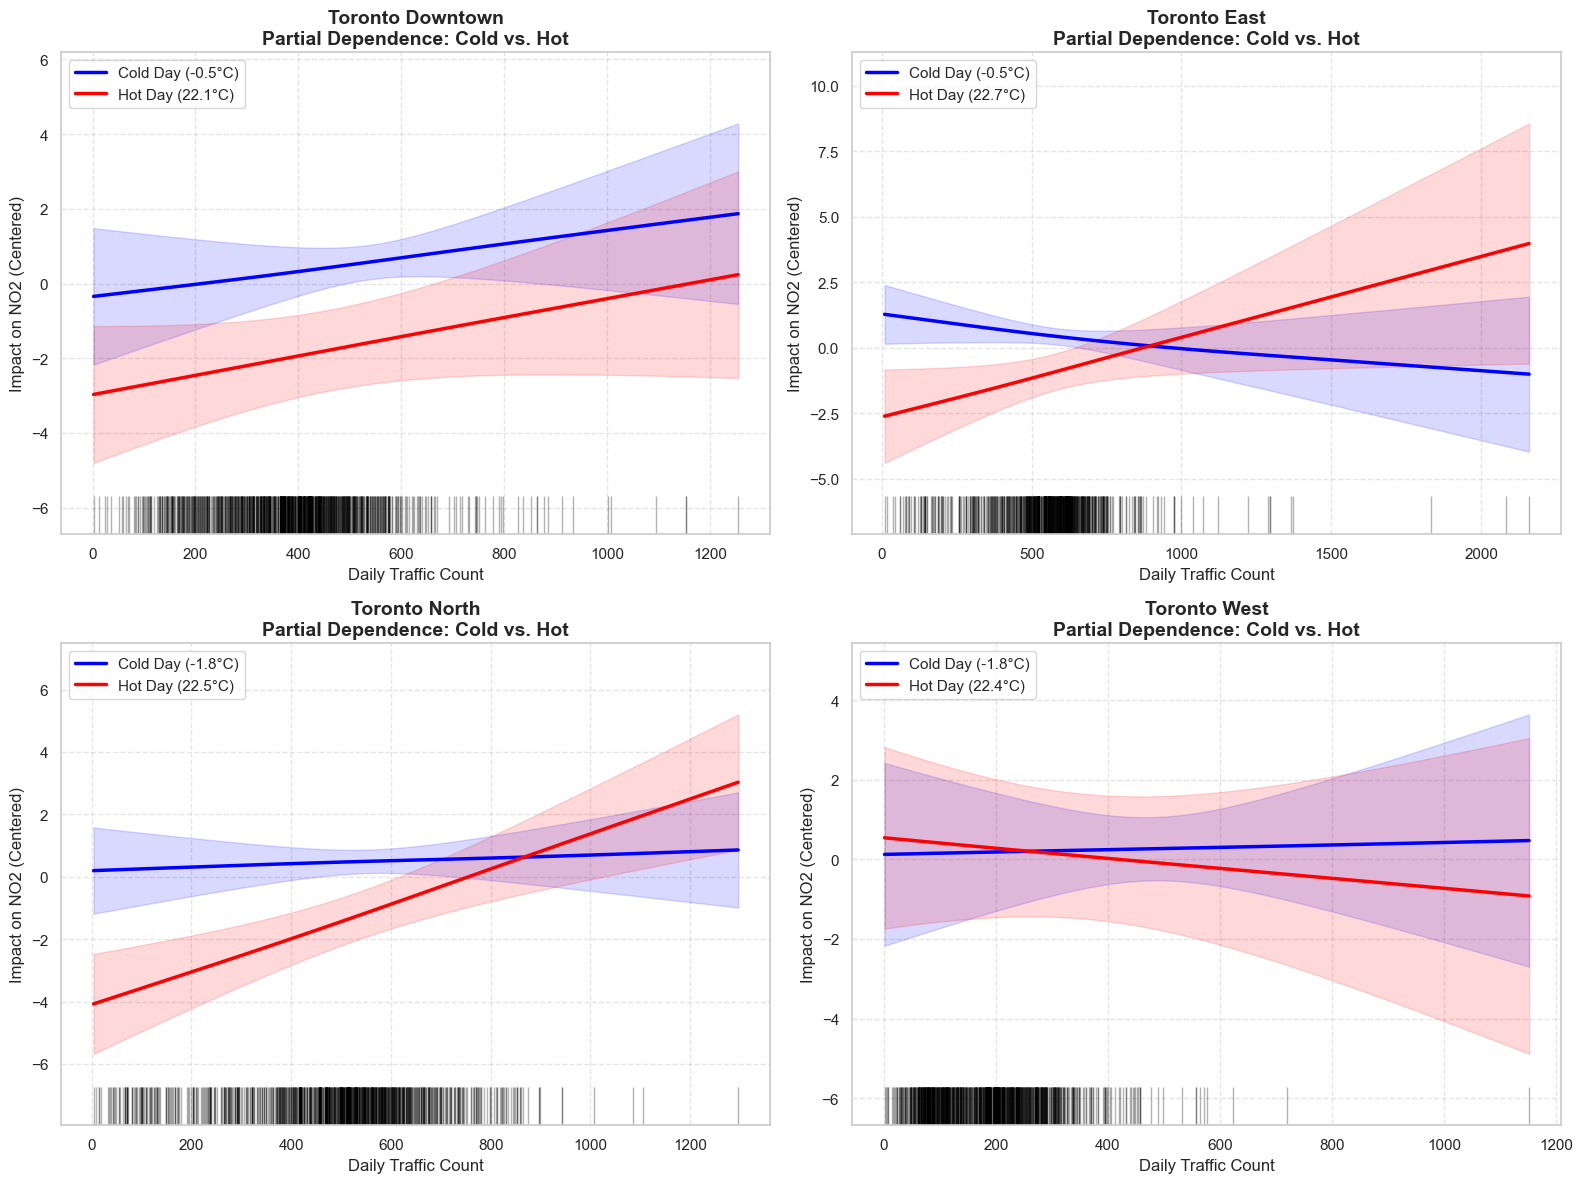

✅ Plot Generated: Shows Relative Impact (Y=0 is average).


In [11]:
from pygam import LinearGAM, s, f, l, te
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- GAM ANALYSIS: TRAFFIC x TEMP INTERACTION (PARTIAL DEPENDENCE) ---

print("Fitting GAMs... Generating relative Partial Dependence Plots (Centered)...")

# 1. Prepare Data
feature_cols = [
    'Traffic_Count',    # Index 0: Interaction A
    'Traffic_Lag1',     # Index 1
    'Temp',             # Index 2: Interaction B
    'Wind_Gust',        # Index 3
    'Wind_Dir',         # Index 4
    'NO2_Lag1',         # Index 5
    'Month'             # Index 6
]

# 2. Formula (Traffic x Temp Interaction)
# te(0, 2) creates the 3D surface
gam_formula = te(0, 2) + s(1) + s(3) + s(4, basis='cp') + s(5) + s(6, basis='cp')

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, station in enumerate(sorted(df_master['Station'].unique())):
    ax = axes[i]
    
    # Isolate Station Data
    df_local = df_master[df_master['Station'] == station].dropna(subset=feature_cols + ['NO2_Mean']).copy()
    if len(df_local) < 50: continue
    
    X = df_local[feature_cols].values
    y = df_local['NO2_Mean'].values
    
    # 3. Fit the GAM
    gam = LinearGAM(gam_formula).gridsearch(X, y, progress=False)
    
    # 4. Create Scenarios (Slicing the 3D Surface)
    # We manually construct the grid to ensure shapes match
    
    temp_cold = np.percentile(df_local['Temp'], 10) 
    temp_hot  = np.percentile(df_local['Temp'], 90)
    
    # Base Matrix (100 rows, filled with MEAN values)
    XX_base = np.zeros((100, len(feature_cols)))
    XX_base[:] = X.mean(axis=0)
    
    traffic_grid = np.linspace(df_local['Traffic_Count'].min(), df_local['Traffic_Count'].max(), 100)
    
    # --- SCENARIO 1: COLD DAY ---
    XX_cold = XX_base.copy()
    XX_cold[:, 0] = traffic_grid  
    XX_cold[:, 2] = temp_cold     
    
    # Use partial_dependence for CENTERED Relative Impact
    pdp_cold, conf_cold = gam.partial_dependence(term=0, X=XX_cold, width=0.95)
    
    # --- SCENARIO 2: HOT DAY ---
    XX_hot = XX_base.copy()
    XX_hot[:, 0] = traffic_grid   
    XX_hot[:, 2] = temp_hot       
    
    pdp_hot, conf_hot = gam.partial_dependence(term=0, X=XX_hot, width=0.95)
    
    # --- PLOTTING ---
    ax.plot(traffic_grid, pdp_cold, color='blue', lw=2.5, label=f'Cold Day ({temp_cold:.1f}°C)')
    ax.fill_between(traffic_grid, conf_cold[:, 0], conf_cold[:, 1], color='blue', alpha=0.15)
    
    ax.plot(traffic_grid, pdp_hot, color='red', lw=2.5, label=f'Hot Day ({temp_hot:.1f}°C)')
    ax.fill_between(traffic_grid, conf_hot[:, 0], conf_hot[:, 1], color='red', alpha=0.15)
    
    # Rug Plot
    sns.rugplot(data=df_local, x='Traffic_Count', ax=ax, color='black', alpha=0.3, height=0.08)
    
    # Formatting
    ax.set_title(f"{station}\nPartial Dependence: Cold vs. Hot", fontsize=14, fontweight='bold')
    ax.set_xlabel("Daily Traffic Count")
    ax.set_ylabel("Impact on NO2 (Centered)") # Clear label difference
    ax.legend(loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("✅ Plot Generated: Shows Relative Impact (Y=0 is average).")
